# DM-14260: Re-run HiTS data processing with current ap_pipe

## An initial look at the inaugural HiTS2015 reprocessing run

We attempted to reprocess HiTS fields Blind15A_26, Blind15A_40, and Blind15A_42 (g filter only) for the first time since December 2017. Major changes in ap_pipe include adding crosstalk correction to DECam and changes to the association database. The dataset processed corresponds to that in [ap_verify_hits2015](https://github.com/lsst/ap_verify_hits2015).

Note that the coadd templates made from the correspondingBlind14A fields used have not changed, and we suspect this is the source of many of the oddities in the results from the initial processing run.

## tl;dr

The reprocessing was only partially successful. About 1/3 of the visits didn't run at all. This problem will be investigated for [DM-14761](https://jira.lsstcorp.org/browse/DM-14761). Meanwhile, we now have a slightly improved light curve plotter that has placeholders for exposure cutouts!

In [1]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import sqlite3
#import datetime
from astropy.time import Time
import lsst.daf.persistence as dafPersist

workingDir = '/project/mrawls/hits2015/rerun/take1'

In [2]:
butler = dafPersist.Butler(workingDir)

In [3]:
sqliteFile = 'association.db'
connection = sqlite3.connect(os.path.join(workingDir, sqliteFile))

tables = {'obj': 'dia_objects', 'src': 'dia_sources', 'ccd': 'CcdVisit'}

objTable = pd.read_sql_query('select * from {0};'.format(tables['obj']), connection)
srcTable = pd.read_sql_query('select * from {0};'.format(tables['src']), connection)
ccdTable = pd.read_sql_query('select * from {0};'.format(tables['ccd']), connection)

connection.close()

The new database schema is

1. objTable: `id|coord_ra|coord_dec|parent|indexer_id|n_dia_sources|psFluxMean_FILTER|psFluxMeanErr_FILTER|psFluxSigma_FILTER`
(note that the filters for DECam are u, g, r, i, z, y, VR, and N964, and there are columns for mean flux, error, and sigma for each of these, but the data we processed is all in g)
2. srcTable: `id|coord_ra|coord_dec|parent|diaObjectId|ccdVisitId|psFlux|psFluxErr|filterName|filterId`
3. ccdTable: `ccdVisitId|ccdNum|filterName|ra|decl|expTime|expMidptMJD|fluxZeroPoint|fluxZeroPointErr`


## Plot how many DIASources comprise any given DIAObject

<IPython.core.display.Javascript object>


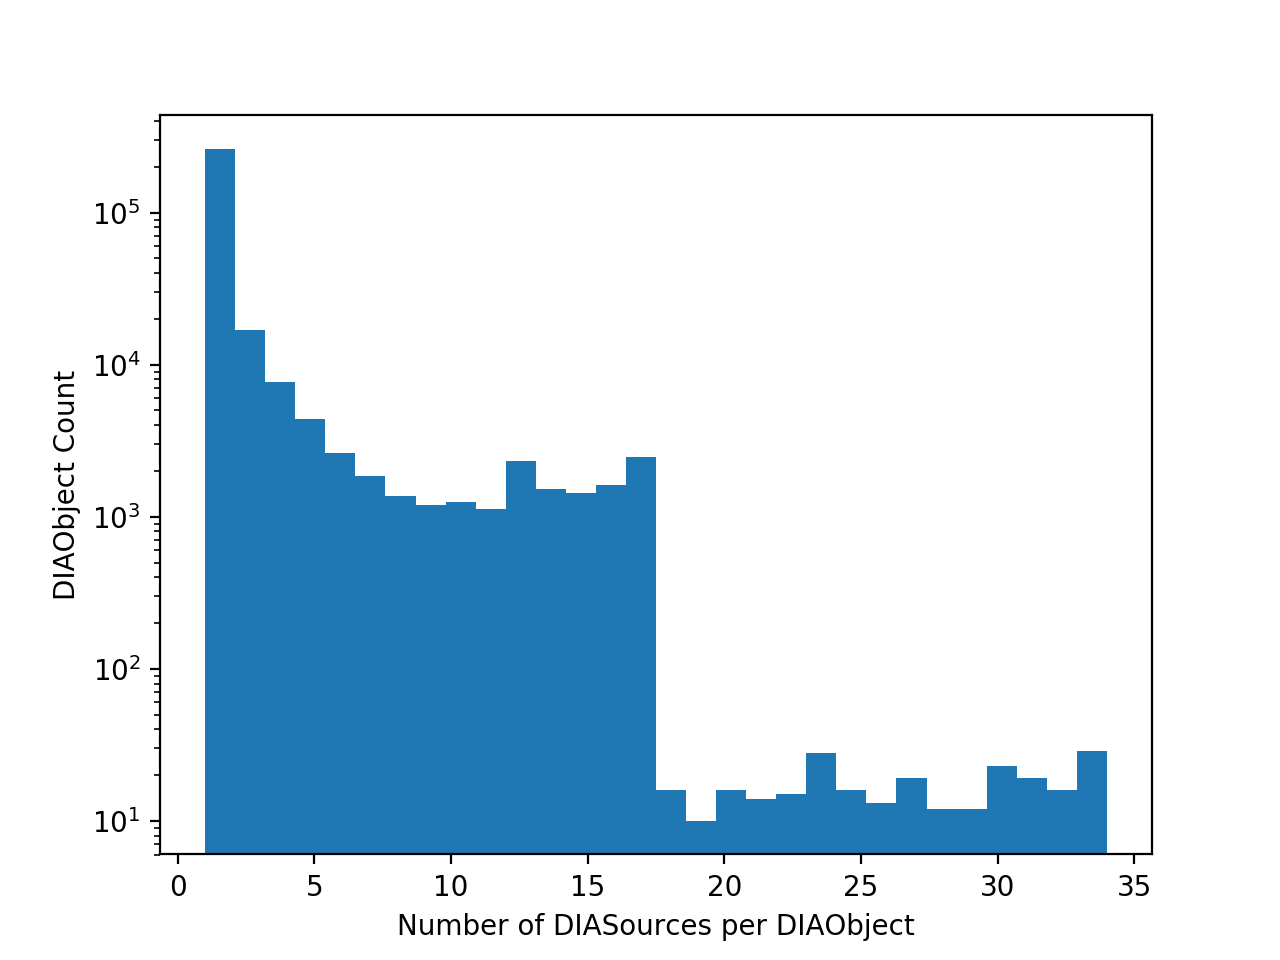

In [4]:
#obj_id = objTable['id'].values  # object ids from the objTable
count = objTable['n_dia_sources'].values
plt.hist(count, bins=30)
plt.yscale('log')
plt.xlabel('Number of DIASources per DIAObject')
plt.ylabel('DIAObject Count')

Already this is interesting, because this histogram looks different than its earlier counterpart, which had some bogus associations all the way up to 40-50+ sources per object! However, the drop-off at 17 rather than 24 is unexpected, since we supposedly processed 24 visits...

Closer inspection of the actual output directories on disk (heresy, I know) reveals that only visits falling in the numerical range 410915--412324 were processed successfully. The rest (in the range 412504--421606) have essentially empty output directories (and no output directories in the difference imaging output location). So 33 of the 84 visits weren't processed at all.

## Plot DIAObjects on the sky

<IPython.core.display.Javascript object>


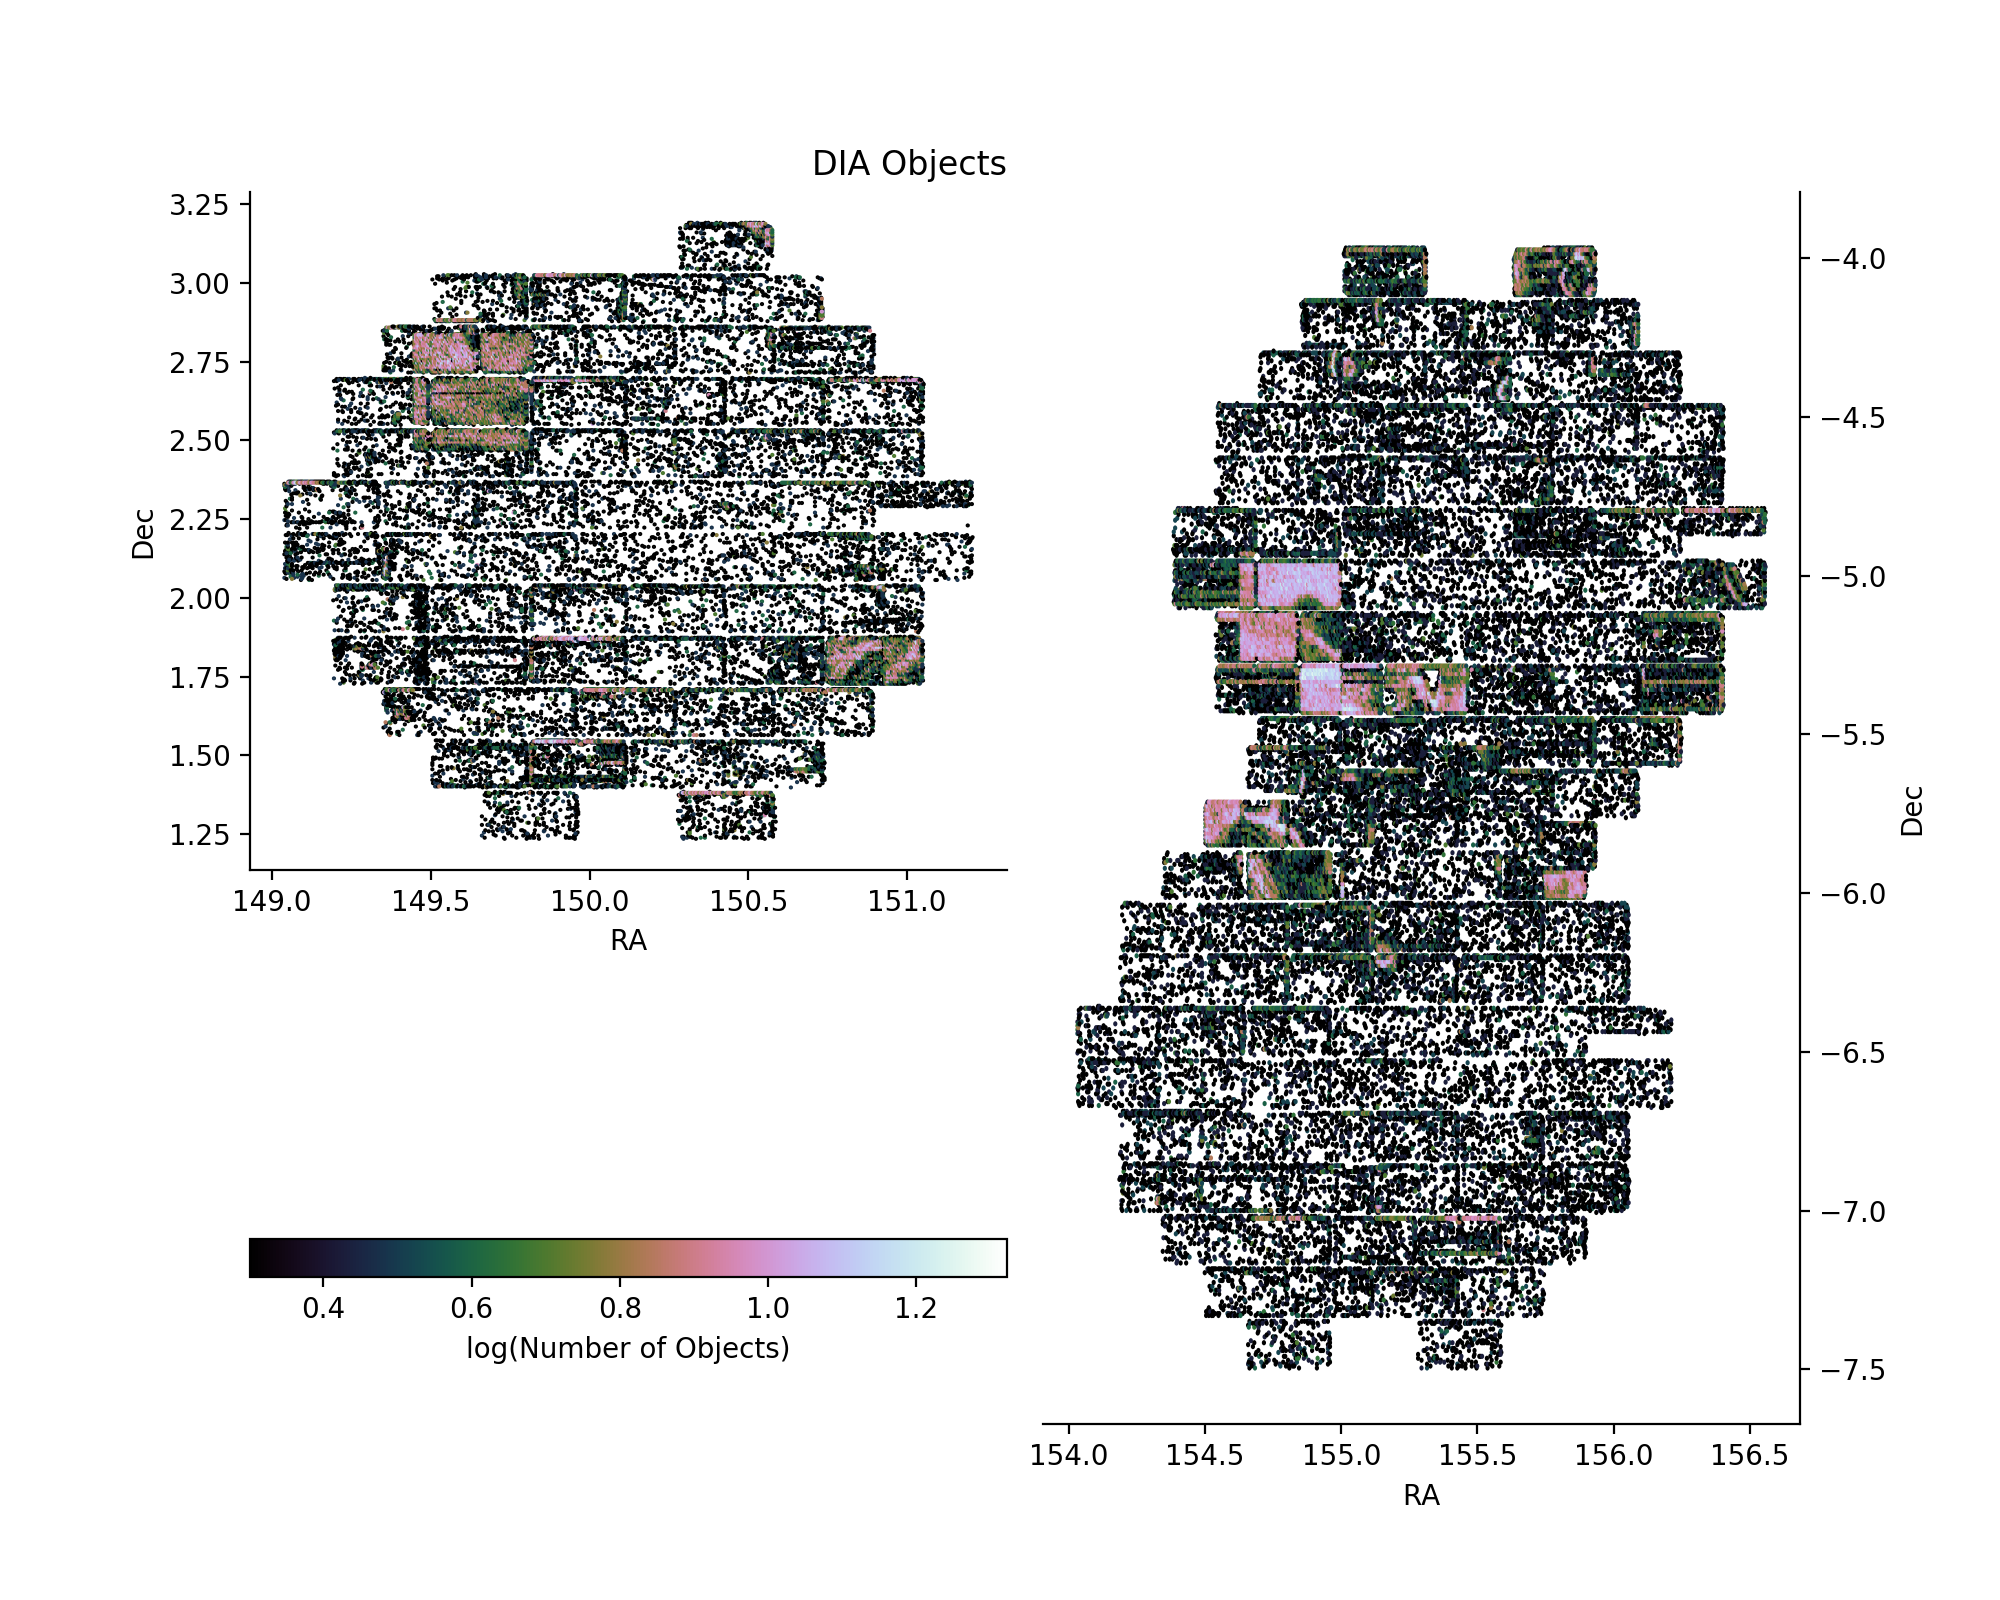

In [5]:
fig = plt.figure(facecolor='white', figsize=(10,8))
plt.subplots_adjust(wspace=0.1, hspace=0)

# Make two "subsets" of sources on the sky, with a declination cut
dec_set1 = (objTable['coord_dec'] > -2)
dec_set2 = ~dec_set1

# Panel 1: one HiTS field
ax1 = plt.subplot2grid((4,4), (0,0), rowspan=4, colspan=2)
ax1.set_facecolor('white')
plot1 = plt.hexbin(objTable.loc[dec_set1, 'coord_ra'], objTable.loc[dec_set1, 'coord_dec'], 
                   cmap='cubehelix', bins='log', gridsize=500, mincnt=1)
plt.title('DIA Objects', loc='right')
plt.xlabel('RA')
plt.ylabel('Dec')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
cb = fig.colorbar(plot1, orientation='horizontal', pad=0.3)
cb.set_label('log(Number of Objects)')

# Panel 2: two (overlapping) HiTS fields
ax2 = plt.subplot2grid((4,4), (0,2), rowspan=4, colspan=2)
ax2.set_facecolor('white')
plot2 = plt.hexbin(objTable.loc[dec_set2, 'coord_ra'], objTable.loc[dec_set2, 'coord_dec'], 
                   cmap='cubehelix', bins='log', gridsize=500, mincnt=1)
plt.xlabel('RA')
plt.ylabel('Dec')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

At a glance, it looks like this subset of visits has many of the same issues as before, which are likely due to the templates.

## Plot DIAObjects on the sky, colored by number of DIASources per DIAObject

In [6]:
#src_count1 = [len(getSourcesFromObject(obj)) for obj in objTable.loc[dec_set1, 'id'].values]
#src_count2 = [len(getSourcesFromObject(obj)) for obj in objTable.loc[dec_set2, 'id'].values]

# Get the count values of sources per object for each subset FIX THISSS
#src_count1 = [objTable['n_dia_sources'] for obj in objTable.loc[dec_set1, 'id'].values]
#src_count2 = [objTable['n_dia_sources'] for obj in objTable.loc[dec_set2, 'id'].values]

src_count1 = objTable.loc[dec_set1, 'n_dia_sources']
src_count2 = objTable.loc[dec_set2, 'n_dia_sources']

<IPython.core.display.Javascript object>


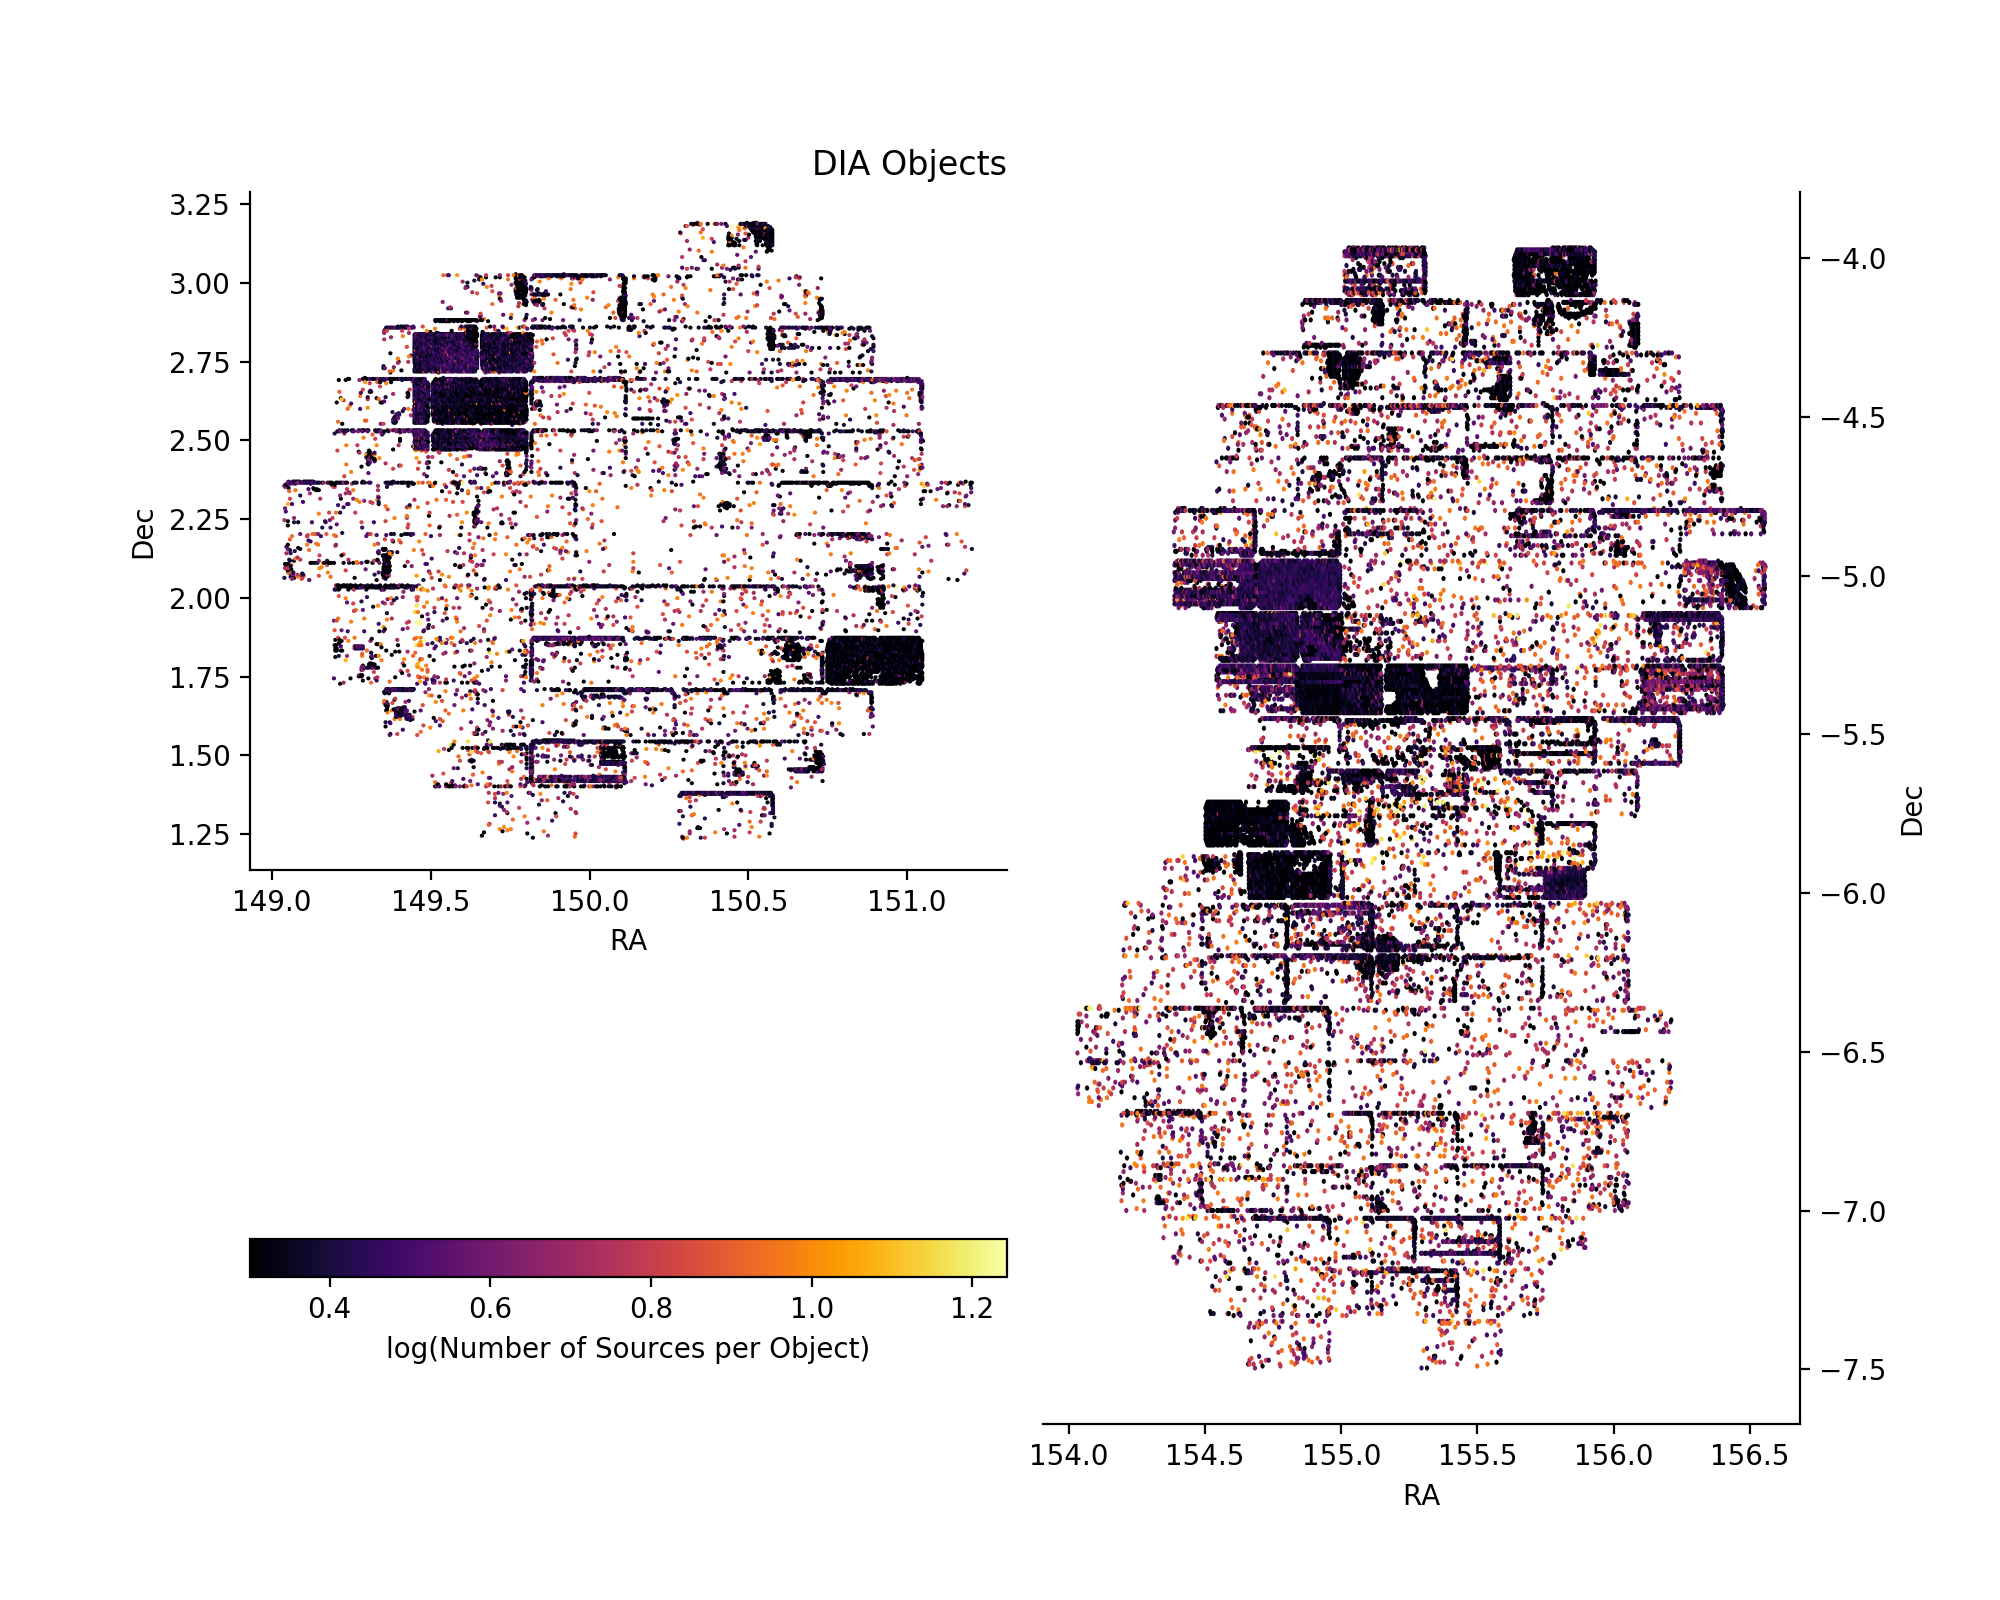

In [7]:
fig = plt.figure(facecolor='white', figsize=(10,8))
plt.subplots_adjust(wspace=0.1, hspace=0)

# Panel 1: one HiTS field
ax1 = plt.subplot2grid((4,4), (0,0), rowspan=4, colspan=2)
ax1.set_facecolor('white')
plot1 = plt.hexbin(objTable.loc[dec_set1, 'coord_ra'], objTable.loc[dec_set1, 'coord_dec'], C=src_count1,
                   cmap='inferno', bins='log', gridsize=500, mincnt=1)
plt.title('DIA Objects', loc='right')
plt.xlabel('RA')
plt.ylabel('Dec')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
cb = fig.colorbar(plot1, orientation='horizontal', pad=0.3)
cb.set_label('log(Number of Sources per Object)')

# Panel 2: two (overlapping) HiTS fields
ax2 = plt.subplot2grid((4,4), (0,2), rowspan=4, colspan=2)
ax2.set_facecolor('white')
plot2 = plt.hexbin(objTable.loc[dec_set2, 'coord_ra'], objTable.loc[dec_set2, 'coord_dec'], C=src_count2,
                   cmap='inferno', bins='log', gridsize=500, mincnt=1)
plt.xlabel('RA')
plt.ylabel('Dec')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

## Light curves and cutouts

The association database now includes information about fluxes, so this is much easier than before!

At least... it is if we know how to use pandas properly. First, let's rename some of the column names that are potentially duplicates or otherwise confusing so we don't run into problems if we do some merging and/or joining.

In [8]:
newname = {'id': 'diaSourceId'}
srcTable.rename(index=str, columns=newname, inplace=True)
srcTable.columns

Index(['diaSourceId', 'coord_ra', 'coord_dec', 'parent', 'diaObjectId',
       'ccdVisitId', 'psFlux', 'psFluxErr', 'filterName', 'filterId'],
      dtype='object')

In [9]:
newname = {'id': 'diaObjectId'}
objTable.rename(index=str, columns=newname, inplace=True)
objTable.columns

Index(['diaObjectId', 'coord_ra', 'coord_dec', 'parent', 'indexer_id',
       'n_dia_sources', 'psFluxMean_u', 'psFluxMeanErr_u', 'psFluxSigma_u',
       'psFluxMean_g', 'psFluxMeanErr_g', 'psFluxSigma_g', 'psFluxMean_r',
       'psFluxMeanErr_r', 'psFluxSigma_r', 'psFluxMean_i', 'psFluxMeanErr_i',
       'psFluxSigma_i', 'psFluxMean_z', 'psFluxMeanErr_z', 'psFluxSigma_z',
       'psFluxMean_y', 'psFluxMeanErr_y', 'psFluxSigma_y', 'psFluxMean_VR',
       'psFluxMeanErr_VR', 'psFluxSigma_VR', 'psFluxMean_N964',
       'psFluxMeanErr_N964', 'psFluxSigma_N964'],
      dtype='object')

### merge merge merge

In [10]:
superTable = objTable.merge(srcTable[['psFlux', 'psFluxErr', 'ccdVisitId', 'diaObjectId']], on='diaObjectId')
superTimeTable = superTable.merge(ccdTable[['ccdVisitId', 'expMidptMJD']], on='ccdVisitId')
superTimeTable.sort_values('diaObjectId', inplace=True)

### Can now use `groupby` to access each DIAObject's information (like time and flux)

In [11]:
# But first, some awfulness with daf_base DateTime

from lsst.daf.base import DateTime
testdataId = {'visit': 410929, 'ccd': 47}
calexp = butler.get('calexp', testdataId)
test = calexp.getInfo().getVisitInfo().getDate()
print(test)
print(test.nsecs())
print(test.toPython())
test2 = 1.42414343e+09
print(DateTime(int(test2)))

DateTime("2015-02-17T03:50:49.190385000", TAI)
1424145049190385000
2015-02-17 03:50:49.190385
DateTime("1970-01-01T00:00:01.424143430", TAI)


<IPython.core.display.Javascript object>


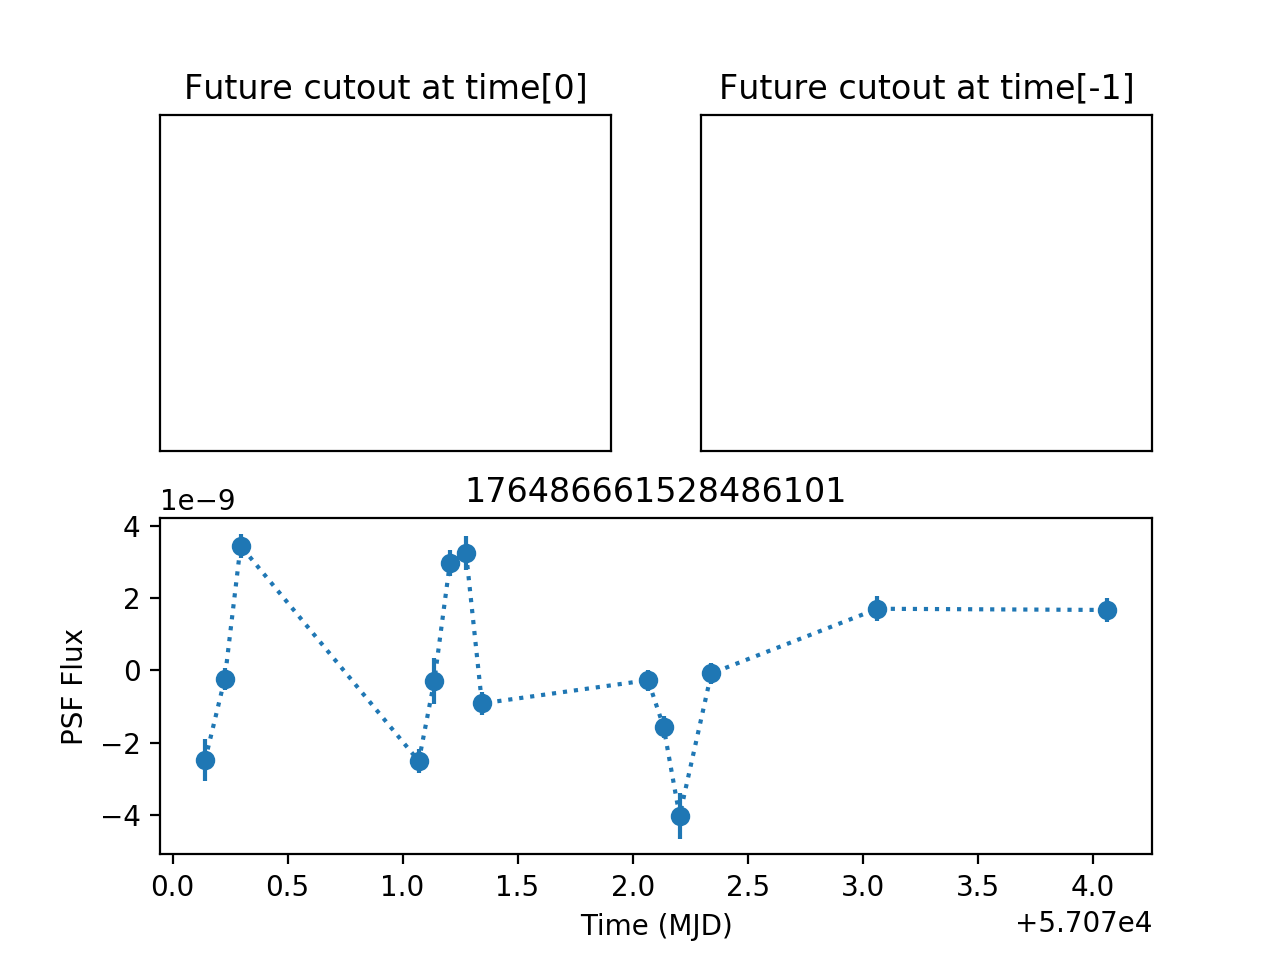

<IPython.core.display.Javascript object>


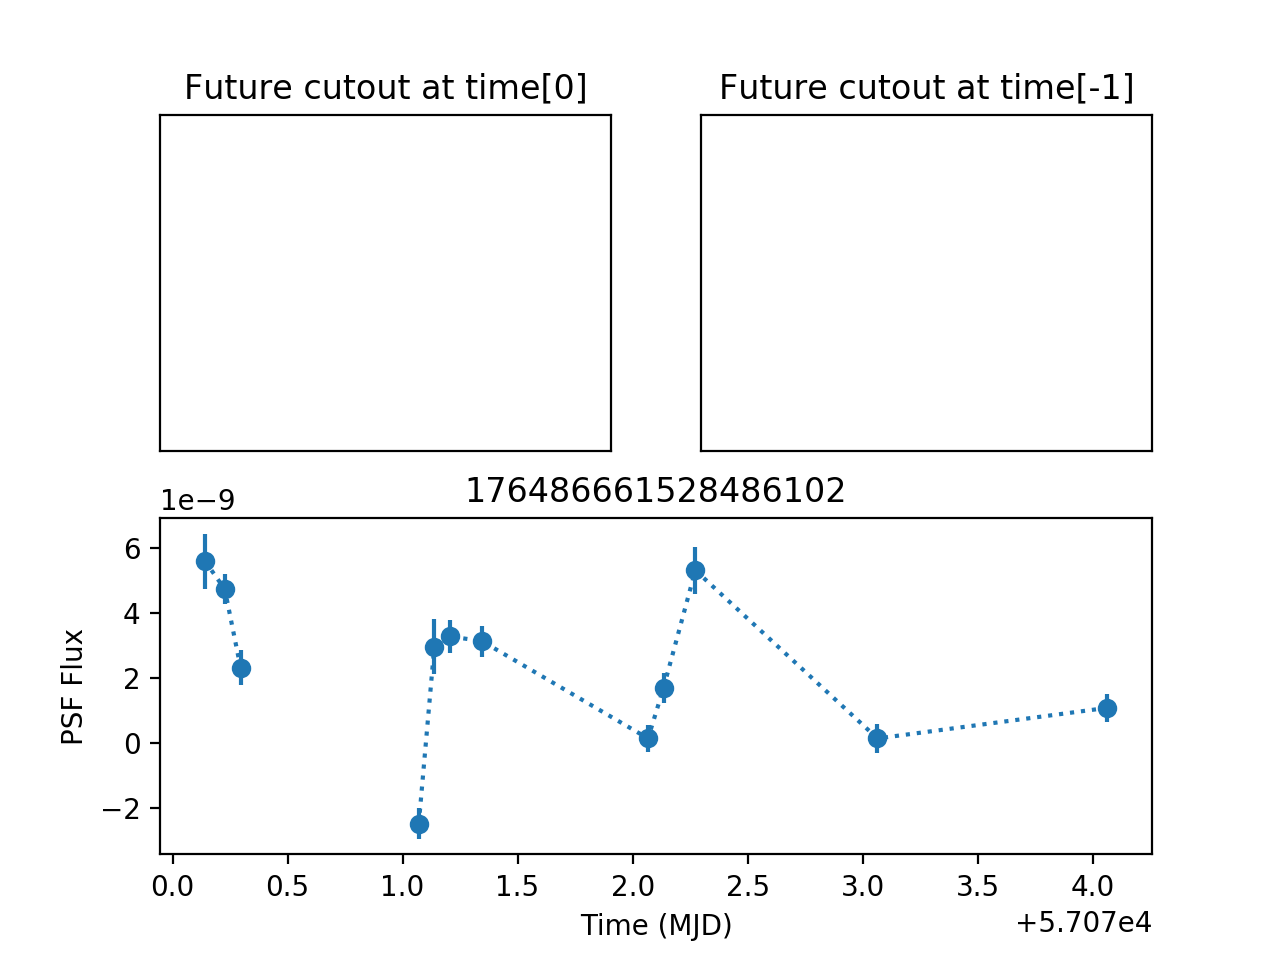

<IPython.core.display.Javascript object>


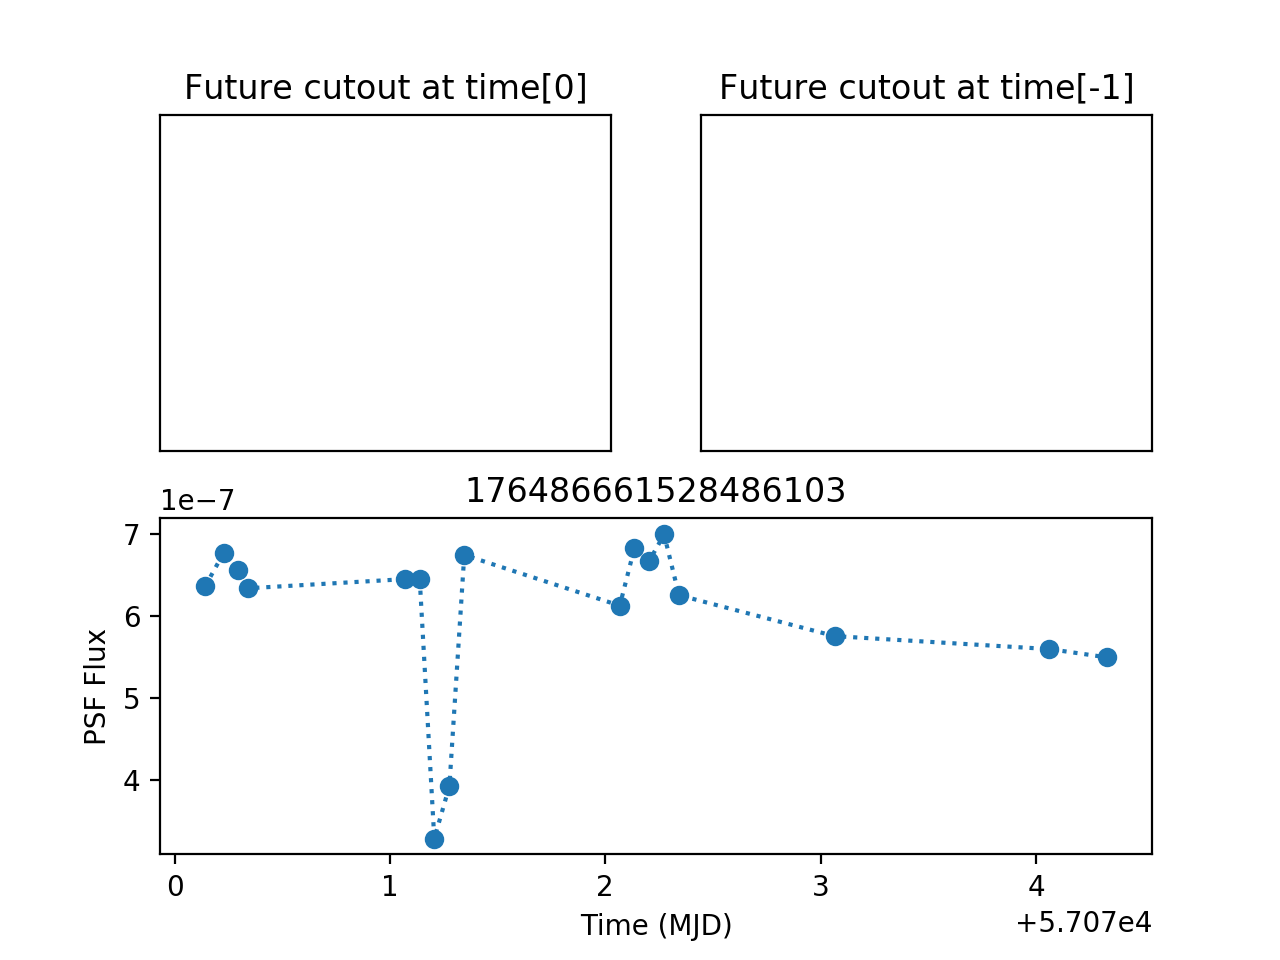

<IPython.core.display.Javascript object>


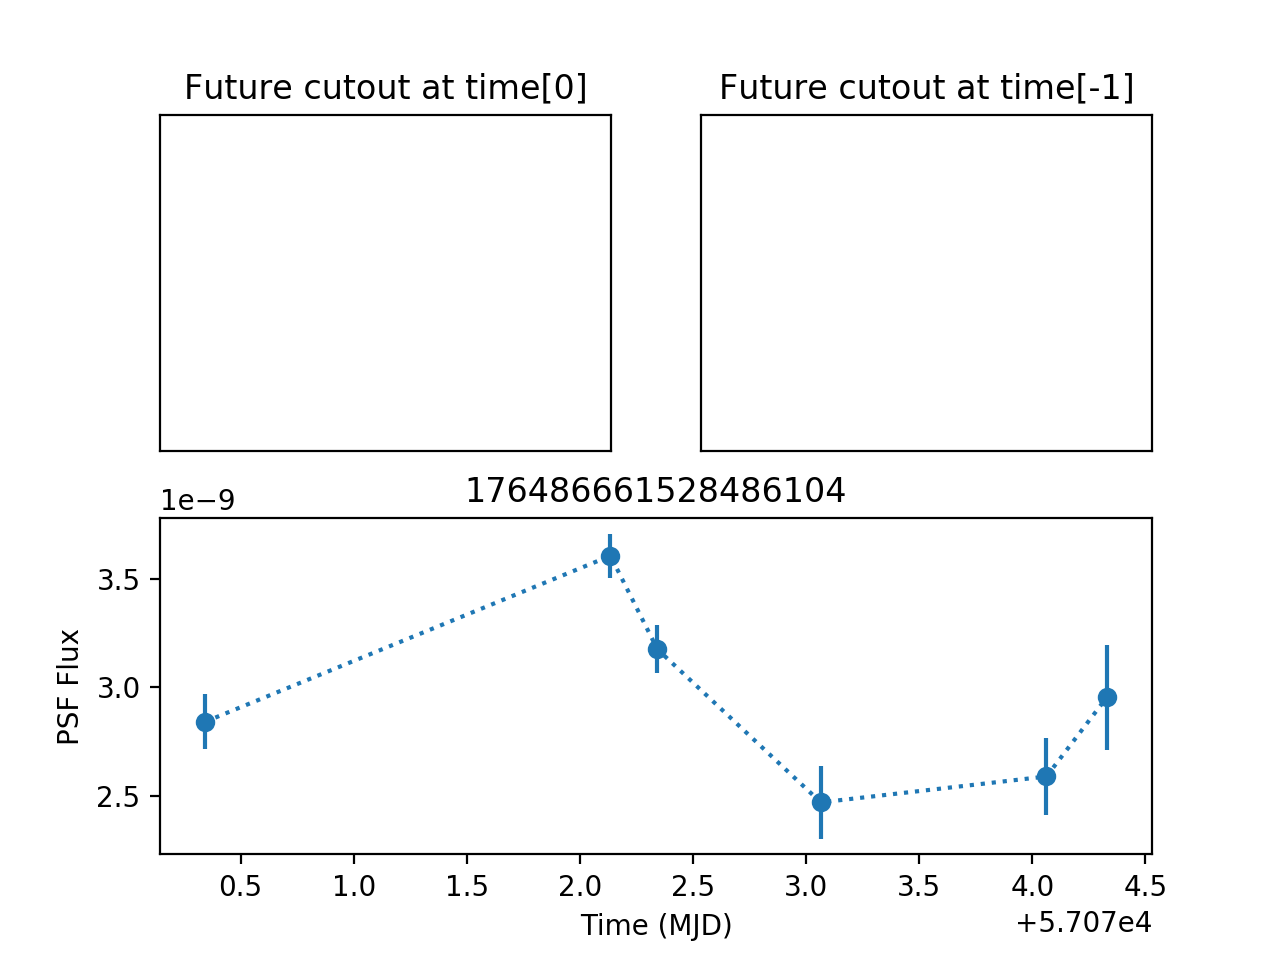

In [12]:
# For reals now: a groupby party

objGroup = superTimeTable[0:50].groupby('diaObjectId')
for obj, group in objGroup:
    #print(obj, len(group), group['expMidptMJD'].values, group['psFlux'].values)
    plt.figure()
    plt.subplot(212)
    rawtimes = group['expMidptMJD'].values
    #print(rawtimes)
    #print([DateTime(np.int64(time*1.e9)) for time in rawtimes])
    times = [DateTime(np.int64(time*1.e9)).get() for time in rawtimes]
    #print(times)
    astropy_times = Time(times, format='mjd')
    #print(astropy_times)
    sortidx = astropy_times.argsort()
    astropy_times = astropy_times[sortidx]
    #print(astropy_times.sort())  # equivalent, but no good for parallel arrays
    fluxes = group['psFlux'].values[sortidx]
    fluxerrs = group['psFluxErr'].values[sortidx]
    plt.errorbar(astropy_times.mjd, fluxes, yerr=fluxerrs, ls=':', marker='o')
    plt.title(obj)
    plt.xlabel('Time (MJD)')
    plt.ylabel('PSF Flux')
    plt.subplot(221)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    # cutout at time[0] goes here
    plt.title('Future cutout at time[0]')
    plt.subplot(222)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    # cutout at time[-1] goes here
    plt.title('Future cutout at time[-1]')

### Or we can do it the way that initially made more sense in my head, but is probably slower and definitely less panda-esque

In [13]:
# fluxes come from srcTable, and each has a ccdVisitId
# times come from ccdTable, which also has a ccdVisitId column
objIds = objTable['diaObjectId'][0:10]  # 10 DIAObjects
for objId in objIds.values:
    srcIds = srcTable.loc[srcTable['diaObjectId'] == objId, 'diaObjectId']  # sources that are in an object
    #print('objId: ', objId, 'srcIds: ', srcIds.values)
    fluxes = []
    fluxerrs = []
    dataIds = []
    times = []
    for srcId in srcIds:
        fluxes.append(srcTable.loc[srcTable['diaSourceId'] == srcId, 'psFlux'].values[0])  # fluxes for each source
        fluxerrs.append(srcTable.loc[srcTable['diaSourceId'] == srcId, 'psFluxErr'].values[0])
        dataId = srcTable.loc[srcTable['diaSourceId'] == srcId, 'ccdVisitId']
        dataIds.append(dataId)
        times.append(ccdTable.loc[ccdTable['ccdVisitId'] == dataId.values[0], 'expMidptMJD'].values[0])
    #print(objId, times, fluxes)
    
#    for srcId in srcIds.values:
#        dataId = ccdTable.loc[srcTable['id'] == srcId, 'ccdVisitId']  # visit and ccd for the source
#        time = ccdTable.loc[ccdTable['ccdVisitId'].values == dataId.values, 'expMidptMJD']
#        print(objId, srcId, dataId.values, time.values)
    #plt.figure()
    #plt.plot(times, fluxes, ls='None', marker='o')
    

Except this doesn't quite work as we'd like, because only grabbing the zeroth indexed "value" only gets a single flux and time for each source. No good.